# Classification d'assertions selons leur valeurs de véracité

In [21]:
# Importation des différentes librairies utiles pour le notebook

!pip install langdetect
!pip install contractions

#Sickit learn met régulièrement à jour des versions et 
#indique des futurs warnings. 
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import seaborn as sns
import seaborn as sb
import matplotlib.pyplot as plt
import sys
import pandas as pd
import numpy as np 
import sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.pipeline import Pipeline

#Sickit learn met régulièrement à jour des versions et indique des futurs warnings. 
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



# Google Drive

In [22]:
#Lier notre drive.
from google.colab import drive
drive.mount('/content/gdrive')

my_local_drive = '/content/gdrive/My Drive/Machine Learning/'
sys.path.append(my_local_drive)
%cd $my_local_drive
%ls -l

from MyNLPUtilities import *

df = pd.read_csv('output_400-400.csv', sep=',')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Machine Learning
total 8152
-rw------- 1 root root  323784 May 18 12:42 'Copie de Projet_Machine_Learning_hyperparam.ipynb'
-rw------- 1 root root   77412 May 12 09:57 'Copie de Projet_Machine_Learning_test.ipynb'
-rw------- 1 root root    3891 May 11 22:03  MyNLPUtilities.py
-rw------- 1 root root 2133202 May 12 08:33  output_1600-1600.csv
-rw------- 1 root root 3450887 May 11 11:27  output_2600-2600.csv
-rw------- 1 root root  538621 May 18 12:43  output_400-400.csv
-rw------- 1 root root     143 May 11 22:07  output_400-400.gsheet
-rw------- 1 root root  739465 May 12 09:48  output_400-700.csv
-rw------- 1 root root 1073392 May 11 11:26  output_800-800.csv
drwx------ 2 root root    4096 May 12 08:23  __pycache__/


# Analyse du jeu de données

In [23]:
import plotly.express as px
from sklearn.decomposition import PCA

print ("Nombre d'occurrences par classe : \n", df['ratingName'].value_counts())
print ("Shape: " + str(df.shape))

Nombre d'occurrences par classe : 
 False    400
True     400
Name: ratingName, dtype: int64
Shape: (800, 14)


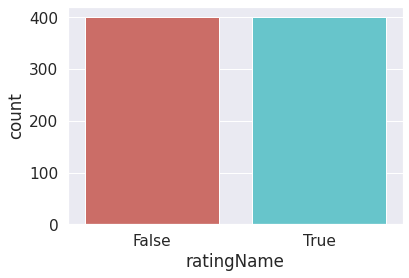

In [24]:
def create_distribution(dataFile):
    return sb.countplot(x='ratingName', data=dataFile, palette='hls')
create_distribution(df)

In [25]:
fig=px.scatter(df, x = 'ratingName',  y="keywords")
fig.show()
display(df.head())

,id,text,date,truthRating,ratingName,author,headline,named_entities_claim,named_entities_article,keywords,source,sourceURL,link,language
0,http://data.gesis.org/claimskg/claim_review/b0...,GOP presidential candidate Ted Cruz ran a 'Net...,Unknown,1,False,Unknown,Ted Cruz Doesn’t Want to ‘Netflix and Chill’ w...,"Netflix,Netflix and Chill,Republican,Ted Cruz,...","Netflix and Chill,Ted Cruz","politics, ted cruz",snopes,http://www.snopes.com,https://www.snopes.com/fact-check/ted-cruz-net...,English
1,http://data.gesis.org/claimskg/claim_review/03...,A woman managed to call 911 during a domestic ...,Unknown,1,False,Unknown,"In Case of Intruder, Should You Ask 911 for a ...","BuzzFeed,Reddit,Reddit gold,Super Bowl,Super B...",NaN,"911 calls, domestic violence",snopes,http://www.snopes.com,https://www.snopes.com/fact-check/case-intrude...,English
2,http://data.gesis.org/claimskg/claim_review/e1...,The California Department of Public Health has...,Unknown,1,False,Unknown,Measles Parties,"ABCNews.com,California Department of Public He...","California Department of Public Health,measles",ASP Article,snopes,http://www.snopes.com,https://www.snopes.com/fact-check/party-scarred/,English
3,http://data.gesis.org/claimskg/claim_review/3c...,Michelle Obama gorged herself on an expensive ...,Unknown,1,False,Unknown,Michelle Obama and Room Service,"2008. Democratic presidential nominee,Alfred...","Michelle Obama,Waldorf-Astoria hotel,room service","ASP Article, barack obama",snopes,http://www.snopes.com,https://www.snopes.com/fact-check/room-for-error/,English
4,http://data.gesis.org/claimskg/claim_review/b4...,A child injured his arm through extended weari...,Unknown,3,True,Unknown,Silly Bandz Danger,"Associated Press,Bonkers,Facebook,Herendeen,Ne...",Silly Bandz,"ASP Article, Parental Nightmares",snopes,http://www.snopes.com,https://www.snopes.com/fact-check/wrist-risk/,English


#Formatage du jeu de données

In [26]:
#Définition variables apprentissage et de prédiction

# Extraction des variables
Xsource = df.source
Xtext = df.text
Xheadline = df.headline
Xauthor = df.author
Xentities = df.named_entities_claim
Xkeywords = df.keywords

#Concaténation du texte à traiter
X = Xtext + Xheadline + Xsource + Xauthor + Xentities + Xkeywords

#Variable de prédiction
y = df['ratingName']


#Normalisation du datatext

In [27]:
#Définition de la fonction MyCleanText pour le pré-traitement du texte
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

def MyCleanText(X,
 lowercase=True, # mettre en minuscule
 removestopwords=False, # supprimer les stopwords
 removedigit=False, # supprimer les nombres
 getstemmer=False, # conserver la racine des termes
 getlemmatisation=False # lematisation des termes
 ):

 sentence=str(X)
 # suppression des caractères spéciaux
 sentence = re.sub(r'[^\w\s]',' ', sentence)
 # suppression de tous les caractères uniques
 sentence = re.sub(r'\s+[a-zA-Z]\s+', ' ', sentence)
 # substitution des espaces multiples par un seul espace
 sentence = re.sub(r'\s+', ' ', sentence, flags=re.I)
 # découpage en mots
 tokens = word_tokenize(sentence)
 if lowercase:
  tokens = [token.lower() for token in tokens]

 # suppression ponctuation
 table = str.maketrans('', '', string.punctuation)
 words = [token.translate(table) for token in tokens]
 # suppression des tokens non alphabetique ou numerique
 words = [word for word in words if word.isalnum()]

 # suppression des tokens numerique
 if removedigit:
  words = [word for word in words if not word.isdigit()]

 # suppression des stopwords
 if removestopwords:
  words = [word for word in words if not word in stop_words]

 # lemmatisation
 if getlemmatisation:
  lemmatizer=WordNetLemmatizer()
  words = [lemmatizer.lemmatize(word)for word in words]

 # racinisation
 if getstemmer:
  ps = PorterStemmer()
  words=[ps.stem(word) for word in words]
 
 sentence= ' '.join(words)
 return sentence


#Définir la classe TextNormalizer qui effectue les prétraitements sur les données
from sklearn.base import BaseEstimator, TransformerMixin
class TextNormalizer(BaseEstimator, TransformerMixin):
 def __init__(self,
 removestopwords=False, # suppression des stopwords
 lowercase=False,# passage en minuscule
 removedigit=False, # supprimer les nombres
 getstemmer=False,# racinisation des termes
 getlemmatisation=False # lemmatisation des termes
 ):
   self.lowercase=lowercase
   self.getstemmer=getstemmer
   self.removestopwords=removestopwords
   self.getlemmatisation=getlemmatisation
   self.removedigit=removedigit

 # Nettoyage du texte
 def transform(self, X, **transform_params):
  X=X.copy() # pour conserver le fichier d'origine
  return [MyCleanText(text,lowercase=self.lowercase, getstemmer=self.getstemmer, removestopwords=self.removestopwords, getlemmatisation=self.getlemmatisation, removedigit=self.removedigit) for text in X]

 def fit(self, X, y=None, **fit_params):
   return self

 def fit_transform(self, X, y=None, **fit_params):
   return self.fit(X).transform(X)

 def get_params(self, deep=True):
   return { 'lowercase':self.lowercase, 'getstemmer':self.getstemmer, 'removestopwords':self.removestopwords, 'getlemmatisation':self.getlemmatisation, 'removedigit':self.removedigit }

 def set_params (self, **parameters):
   for parameter, value in parameters.items():
    setattr(self,parameter,value)
   return self 



# création d'un objet de la classe TextNormalizer
text_normalizer = TextNormalizer(lowercase=True)


# application du fit.transform pour appliquer les pré traitements
X_cleaned = text_normalizer.fit_transform(X)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# création du pipeline
#pipe = Pipeline([("cleaner", TextNormalizer()), ("count_vectorizer", TfidfVectorizer())])
#pipe.fit(X)
#pipe.transform(X)

# creation du dataframe pour affichage
#df_pipe = pd.DataFrame(
# data=pipe.transform(X).toarray(),
# columns=pipe['count_vectorizer'].get_feature_names()
#)


#Création d'un jeu d'apprentissage et de tests

In [28]:
# Transformation du texte en données utilisables par les classifieurs
tf = TfidfVectorizer()
X_transformed = tf.fit_transform(X_cleaned).toarray()

# Séparation du jeu de données
trainsize = 0.8
testsize = 0.2
seed = 30

X_train,X_test,y_train,y_test=train_test_split(X_transformed, y, train_size=trainsize, random_state=seed, test_size=testsize)

texte en italique# Test sur différents classifieurs
1. Classifieur **Gaussian**

Accuracy : 0.588
Classification Report
              precision    recall  f1-score   support

       False    0.57534   0.54545   0.56000        77
        True    0.59770   0.62651   0.61176        83

    accuracy                        0.58750       160
   macro avg    0.58652   0.58598   0.58588       160
weighted avg    0.58694   0.58750   0.58685       160



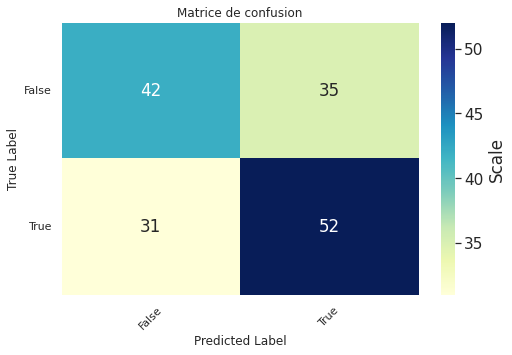

In [29]:
from sklearn.metrics import plot_confusion_matrix

clf = GaussianNB()
clf.fit(X_train, y_train)
result = clf.predict(X_test)

y_pred = clf.predict(X_test)
MyshowAllScores(y_test,y_pred)

2. Classifieur RandomForest

Accuracy : 0.641
Classification Report
              precision    recall  f1-score   support

       False    0.65174   0.93571   0.76833       140
        True    0.52632   0.12500   0.20202        80

    accuracy                        0.64091       220
   macro avg    0.58903   0.53036   0.48517       220
weighted avg    0.60613   0.64091   0.56240       220



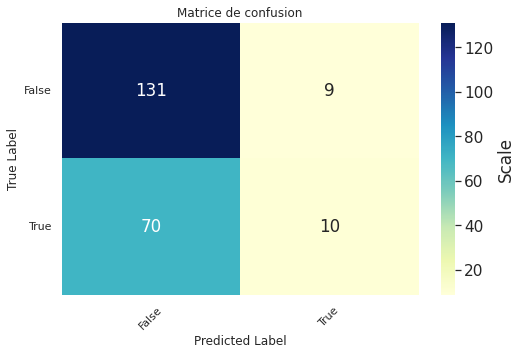

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf2 = RandomForestClassifier()
clf2.fit(X_train, y_train)
result = clf2.predict(X_test)

y_pred = clf2.predict(X_test)
MyshowAllScores(y_test,y_pred)

3. Classifieur DecisionTree

In [99]:
from sklearn.tree import DecisionTreeClassifier
params = {
    'max_depth': [2, 3, 5, 10, 21],
    'min_samples_leaf': [5, 10,16 ,20, 50, 100],
    'criterion': ["gini", "entropy"]
}


results = []
gd_sr = GridSearchCV(estimator=DecisionTreeClassifier(),
param_grid=params,
scoring='accuracy',
cv=5,
n_jobs=1)
gd_sr.fit(X_train, y_train)
result=Result_Parameters(key,gd_sr.best_score_,gd_sr.best_estimator_)
results.append(result) 

results=sorted(results, key=lambda result: result.score, reverse=True)
print("SCORE : " + str(results[0].score))
print("SCORE : " + str(results[0].parameters))
#MyshowAllScores(y_test,results[0].score)

SCORE : 0.5859375
SCORE : DecisionTreeClassifier(criterion='entropy', max_depth=16, min_samples_leaf=21)


Fitting 4 folds for each of 70 candidates, totalling 280 fits
Accuracy : 0.556
Classification Report
              precision    recall  f1-score   support

       False    0.52727   0.75325   0.62032        77
        True    0.62000   0.37349   0.46617        83

    accuracy                        0.55625       160
   macro avg    0.57364   0.56337   0.54324       160
weighted avg    0.57537   0.55625   0.54035       160



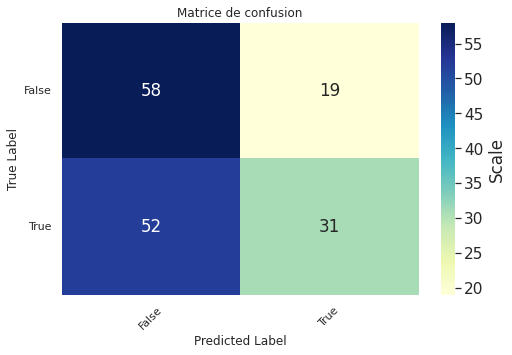

In [62]:
from sklearn.tree import DecisionTreeClassifier

params = {
    'max_depth': [2,4,6,8,10,12,200],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
dt = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")
grid_search.fit(X_train, y_train)


score_df = pd.DataFrame(grid_search.cv_results_)
score_df.head()

score_df.nlargest(5,"mean_test_score")

grid_search.best_estimator_
dt_best = grid_search.best_estimator_


MyshowAllScores(y_test,dt_best.predict(X_test))

4. Classifieur KNeighbors

Accuracy : 0.600
Classification Report
              precision    recall  f1-score   support

       False    0.67333   0.72143   0.69655       140
        True    0.44286   0.38750   0.41333        80

    accuracy                        0.60000       220
   macro avg    0.55810   0.55446   0.55494       220
weighted avg    0.58952   0.60000   0.59356       220



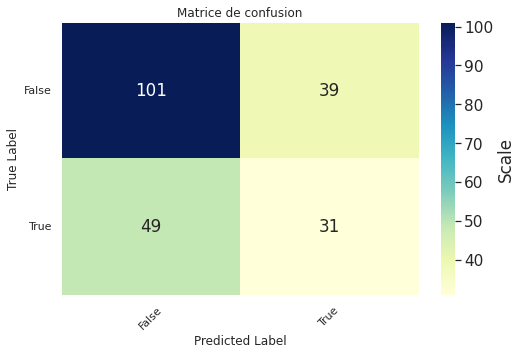

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf4 = KNeighborsClassifier()
clf4.fit(X_train, y_train)
result = clf4.predict(X_test)

y_pred = clf4.predict(X_test)
MyshowAllScores(y_test,y_pred)

5. Classifieur MultinomialNB

Accuracy : 0.636
Classification Report
              precision    recall  f1-score   support

       False    0.63636   1.00000   0.77778       140
        True    0.00000   0.00000   0.00000        80

    accuracy                        0.63636       220
   macro avg    0.31818   0.50000   0.38889       220
weighted avg    0.40496   0.63636   0.49495       220



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



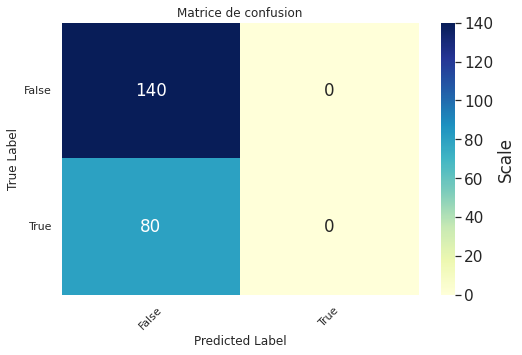

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf5 = MultinomialNB()
clf5.fit(X_train, y_train)
result = clf5.predict(X_test)

y_pred = clf5.predict(X_test)
MyshowAllScores(y_test,y_pred)

6. Classifieur LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

#clf6 = LogisticRegression()
#clf6.fit(X_train, y_train)
#result = clf6.predict(X_test)

params  = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]


results = []
gd_sr = GridSearchCV(estimator=LogisticRegression(),
param_grid=params,
scoring='accuracy',
cv=10,
n_jobs=-1)
gd_sr.fit(X_train, y_train)
result=Result_Parameters(key,gd_sr.best_score_,gd_sr.best_estimator_)
results.append(result) 

results=sorted(results, key=lambda result: result.score, reverse=True)
print("SCORE : " + str(results[0].score))
print("SCORE : " + str(results[0].parameters))


y_pred = model.predict(X_test)
MyshowAllScores(y_test,y_pred)


7. Classifieur SVM

Accuracy : 0.632
Classification Report
              precision    recall  f1-score   support

       False    0.63594   0.98571   0.77311       140
        True    0.33333   0.01250   0.02410        80

    accuracy                        0.63182       220
   macro avg    0.48464   0.49911   0.39860       220
weighted avg    0.52590   0.63182   0.50074       220



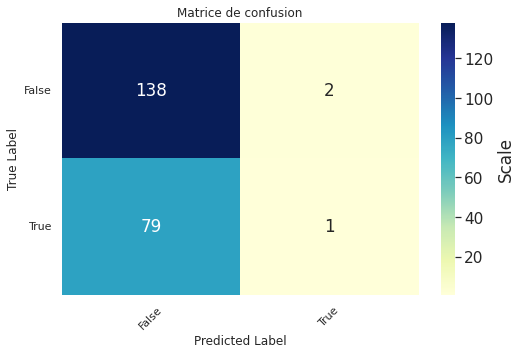

In [ ]:
from sklearn import svm
clf8 = svm.SVC()
clf8.fit(X_train, y_train)
result = clf8.predict(X_test)

y_pred = clf8.predict(X_test)
MyshowAllScores(y_test,y_pred)

# Comparaison des classifieurs

1. Accuracy


In [ ]:
models = []
models.append(('MultinomialNB',MultinomialNB()))
models.append(('LR', LogisticRegression(solver='lbfgs')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC()))

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

score = 'accuracy'
allresults = []
results = []
names = []

for name,model in models:
 # cross validation en 10 fois
 kfold = KFold(n_splits=10, random_state=seed, shuffle=True)

 print ("Evaluation de ",name)
 start_time = time.time()

 # application de la classification
 cv_results = cross_val_score(model, X_transformed, y, cv=kfold, scoring=score)

 thetime=time.time() - start_time
 result=Result(name,cv_results.mean(),cv_results.std(),thetime)
 allresults.append(result)
 
 # pour affichage
 results.append(cv_results)
 names.append(name)

allresults=sorted(allresults, key=lambda result: result.scoremean, reverse=True)

 # affichage résultats

print ('\n Tous les résultats :')
for result in allresults:
 print ('Classifier : ',result.name,
 ' %s : %0.3f' %(score,result.scoremean),
 ' (%0.3f)'%result.stdresult,
 ' en %0.3f '%result.timespent,' s')

print ('\nLe meilleur resultat : ')
print ('Classifier : ',allresults[0].name, ' %s : %0.3f' %(score,allresults[0].scoremean), 
       ' (%0.3f)'%allresults[0].stdresult, ' en %0.3f '%allresults[0].timespent,' s\n')

Evaluation de  MultinomialNB
Evaluation de  LR
Evaluation de  KNN
Evaluation de  CART
Evaluation de  RF
Evaluation de  SVM

 Tous les résultats :
Classifier :  KNN  accuracy : 0.647  (0.074)  en 1.970   s
Classifier :  RF  accuracy : 0.647  (0.053)  en 45.870   s
Classifier :  LR  accuracy : 0.637  (0.044)  en 9.150   s
Classifier :  SVM  accuracy : 0.635  (0.050)  en 127.816   s
Classifier :  MultinomialNB  accuracy : 0.635  (0.047)  en 1.041   s
Classifier :  CART  accuracy : 0.585  (0.029)  en 24.598   s

Le meilleur resultat : 
Classifier :  KNN  accuracy : 0.647  (0.074)  en 1.970   s



[Text(0, 0, 'MultinomialNB'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'KNN'),
 Text(0, 0, 'CART'),
 Text(0, 0, 'RF'),
 Text(0, 0, 'SVM')]

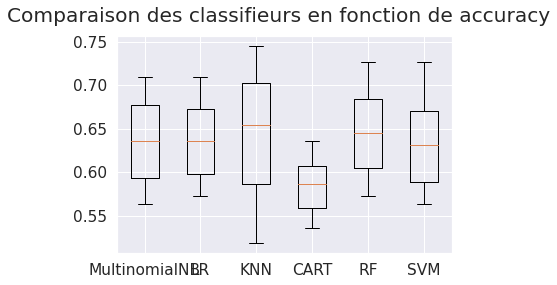

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.suptitle('Comparaison des classifieurs en fonction de accuracy')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

2. Recall

In [ ]:
score = 'recall'
allresults = []
results = []
names = []

for name,model in models:
 # cross validation en 10 fois
 kfold = KFold(n_splits=10, random_state=seed, shuffle=True)

 print ("Evaluation de ",name)
 start_time = time.time()

 # application de la classification
 cv_results = cross_val_score(model, X_transformed, y, cv=kfold, scoring=score)

 thetime=time.time() - start_time
 result=Result(name,cv_results.mean(),cv_results.std(),thetime)
 allresults.append(result)
 # pour affichage
 results.append(cv_results)
 names.append(name)

allresults=sorted(allresults, key=lambda result: result.scoremean, reverse=True)

 # affichage des résultats

print ('\nTous les résultats :')
for result in allresults:
 print ('Classifier : ',result.name,
 ' %s : %0.3f' %(score,result.scoremean),
 ' (%0.3f)'%result.stdresult,
 ' en %0.3f '%result.timespent,' s')

print ('\nLe meilleur resultat : ')
print ('Classifier : ',allresults[0].name, ' %s : %0.3f' %(score,allresults[0].scoremean), 
       ' (%0.3f)'%allresults[0].stdresult, ' en %0.3f '%allresults[0].timespent,' s\n')

Evaluation de  MultinomialNB
Evaluation de  LR
Evaluation de  KNN
Evaluation de  CART
Evaluation de  RF
Evaluation de  SVM

Tous les résultats :
Classifier :  CART  recall : 0.370  (0.098)  en 26.730   s
Classifier :  KNN  recall : 0.366  (0.090)  en 1.991   s
Classifier :  RF  recall : 0.111  (0.066)  en 44.887   s
Classifier :  LR  recall : 0.041  (0.030)  en 10.049   s
Classifier :  SVM  recall : 0.011  (0.017)  en 119.277   s
Classifier :  MultinomialNB  recall : 0.000  (0.000)  en 0.890   s

Le meilleur resultat : 
Classifier :  CART  recall : 0.370  (0.098)  en 26.730   s



[Text(0, 0, 'MultinomialNB'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'KNN'),
 Text(0, 0, 'CART'),
 Text(0, 0, 'RF'),
 Text(0, 0, 'SVM')]

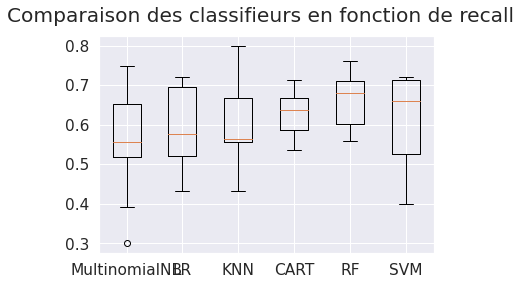

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.suptitle('Comparaison des classifieurs en fonction de recall')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)